In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import seaborn as sns
import pandas as pd

from sklearn.datasets import make_blobs, load_breast_cancer
from sklearn.metrics import euclidean_distances
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils import Bunch

In [2]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [10]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    # Define colors for each category
    palete = plt.get_cmap('bwr')
    color_cycle = [palete(0.0), palete(1.0)]  # Define specific colors

    # Handle the case where there is only one unique value
    if len(unique_y) == 1:
        single_color = color_cycle[0] if unique_y[0] == 0 else color_cycle[1]
        color_cycle = [single_color] * len(unique_y)

    for i, (yy, color) in enumerate(zip(unique_y, color_cycle)):
        mask = y == yy
        if c is None:
            current_color = color
        elif len(c) > 1:
            current_color = c[i]
        else:
            current_color = c
        
        if np.mean(colorConverter.to_rgb(current_color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, color=current_color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

In [158]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,                      
                        cm=None, linewidth=None, threshold=None, linestyle="solid"):
    if cm is None:
        cm = ListedColormap(['#0000aa', '#ff2020'])
    
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

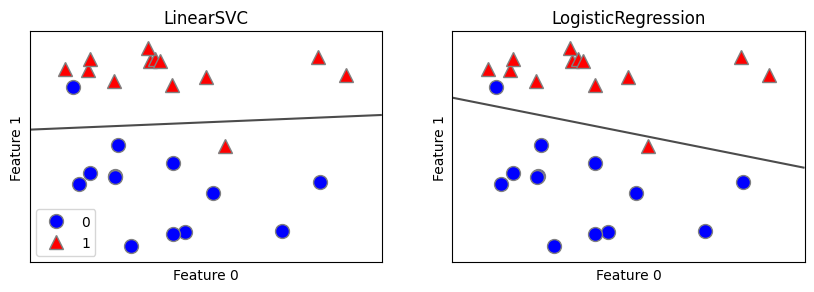

In [22]:
X, y = make_forge()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

for model, ax in zip([LinearSVC(), LogisticRegression()], axes):
    clf = model.fit(X, y)
    plot_2d_separator(clf, X, fill=False, eps=0.5,
                                    ax=ax, alpha=.7)
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("Feature 0")
    ax.set_ylabel("Feature 1")
axes[0].legend()

**LinearSVC** es una implementación del clasificador SVM (Support Vector Machine) para problemas de clasificación. El parámetro C controla la regularización en este modelo y afecta el equilibrio entre maximizar el margen de separación y minimizar el error de clasificación.

**Logistic Regression** es un modelo de clasificación utilizado para predecir la probabilidad de una clase basada en una o más características. Al igual que en LinearSVC, el parámetro C controla la regularización en Logistic Regression y afecta la relación entre el ajuste del modelo y la complejidad del mismo.

La regularización se basa en la penalización de los coeficientes mediante una norma L2 (regularización L2) por defecto. Sin embargo, también se puede aplicar regularización L1 (penalización de la suma de los valores absolutos de los coeficientes) si se especifica el parámetro penalty='l1'.

- Menor C: Aumenta la regularización, resultando en un modelo más simple y generalizado. Esto ayuda a evitar el sobreajuste, especialmente en conjuntos de datos más pequeños o ruidosos.
- Mayor C: Disminuye la regularización, permitiendo un modelo más complejo que puede ajustarse mejor a los datos de entrenamiento. Esto puede ser beneficioso con conjuntos de datos grandes y bien distribuidos, pero puede llevar al sobreajuste.

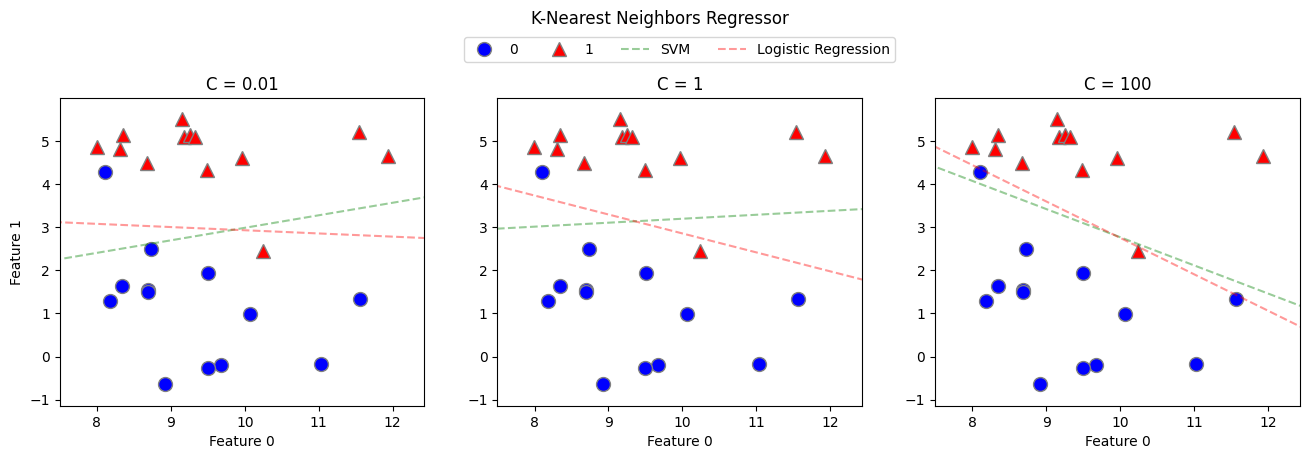

In [108]:
X, y = make_forge()

Regularization = [0.01, 1, 100]

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for C, ax in zip(Regularization, axes):
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    lr = LogisticRegression(C=C, tol=0.00001, dual=False).fit(X, y)
    svm = LinearSVC(C=C, tol=0.00001, dual=False).fit(X, y)

    w = svm.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(6, 13)
    yy = a * xx - (svm.intercept_[0]) / w[1]
    ax.plot(xx, yy, c='g', linestyle='--', label='SVM', alpha=0.4)

    w = lr.coef_[0]
    a = -w[0] / w[1]
    xxlr = np.linspace(6, 13)
    yylr = a * xxlr - (lr.intercept_[0]) / w[1]
    ax.plot(xxlr, yylr, c='r', linestyle='--', label='Logistic Regression', alpha=0.4)

    ax.set_title(f"C = {C}")
    ax.set_xlabel("Feature 0")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    axes[0].set_ylabel("Feature 1")

fig.suptitle("K-Nearest Neighbors Regressor", y = 1.1 )
axes[1].legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, 1.22))


In [109]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=42)

In [152]:
logreg = LogisticRegression(max_iter=100000).fit(X_train, y_train)
print("Log Reg C=1")
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

logreg100 = LogisticRegression(C=100, max_iter=100000).fit(X_train, y_train)
print("\nLog Reg C=100")
print("Training set score: {:.3f}".format(logreg100.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

logreg001 = LogisticRegression(C=0.01, max_iter=100000).fit(X_train, y_train)
print("\nLog Reg C=0.01")
print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

Log Reg C=1
Training set score: 0.958
Test set score: 0.958

Log Reg C=100
Training set score: 0.981
Test set score: 0.965

Log Reg C=0.01
Training set score: 0.953
Test set score: 0.951


La gráfica muestra los coeficientes de un modelo de regresión logística (LogisticRegression) con diferentes valores de C (el inverso de la regularización L2). Cada punto en la gráfica representa el valor de un coeficiente para una característica específica del conjunto de datos.

- C=100: Con un valor alto de C, la regularización L2 es baja. Esto permite que los coeficientes sean más grandes. En la gráfica, observamos que los coeficientes están en un rango mayor y no están cercanos a cero. Esto significa que el modelo da más importancia a una mayor cantidad de características, lo que puede llevar a un modelo menos regularizado.
- C=0.001: Con un valor bajo de C, la regularización L2 es alta. Esto fuerza a los coeficientes a ser más pequeños y, en algunos casos, a acercarse a cero. En la gráfica, vemos que la mayoría de los coeficientes están cerca de cero, indicando que el modelo está más regularizado. Esto puede resultar en un modelo que es menos complejo y más robusto contra el sobreajuste.

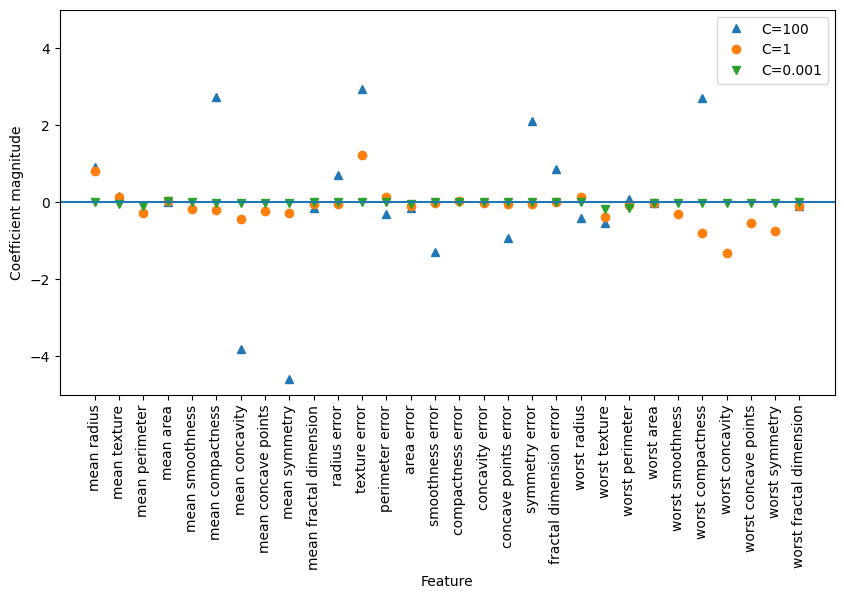

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(logreg100.coef_.T, '^', label="C=100")
plt.plot(logreg.coef_.T, 'o', label="C=1")
plt.plot(logreg001.coef_.T, 'v', label="C=0.001")
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-5, 5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

La regularización L1 (penalty="l1") en la regresión logística es útil para crear modelos más simples y más interpretables al reducir el número de características no nulas. Ajustar C permite controlar el grado de regularización:

- Bajo C: Más regularización, más características con coeficientes iguales a cero.
- Alto C: Menos regularización, más características activas en el modelo.

Training accuracy of l1 logreg with C=0.001: 0.91
Test accuracy of l1 logreg with C=0.001:     0.92
Number of features used: 3 

Training accuracy of l1 logreg with C=1: 0.96
Test accuracy of l1 logreg with C=1:     0.96
Number of features used: 10 

Training accuracy of l1 logreg with C=100: 0.99
Test accuracy of l1 logreg with C=100:     0.98
Number of features used: 23 



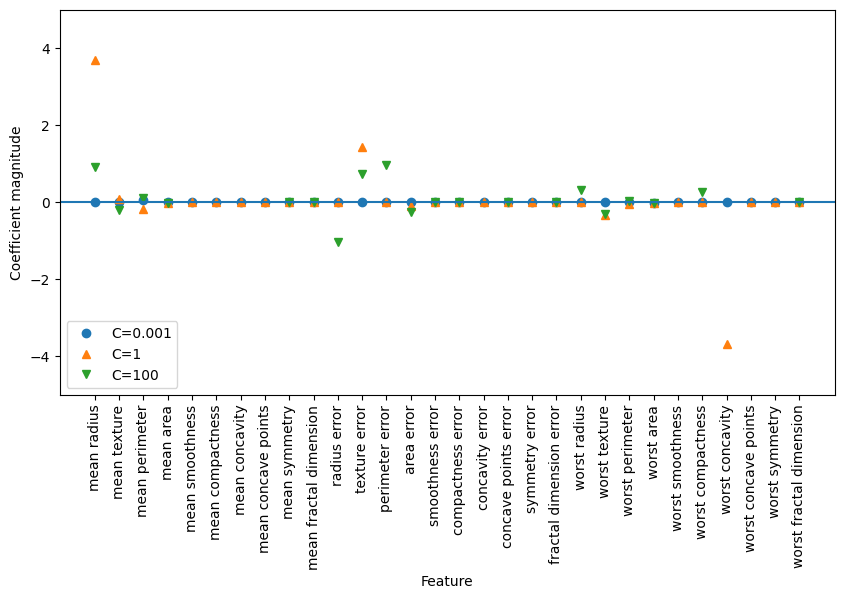

In [157]:
plt.figure(figsize=(10, 5))
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, solver='liblinear', penalty="l1", max_iter=100000).fit(X_train, y_train)
    print("Training accuracy of l1 logreg with C={}: {:.2f}".format(C, lr_l1.score(X_train, y_train)))
    print("Test accuracy of l1 logreg with C={}:     {:.2f}".format(C, lr_l1.score(X_test, y_test)))
    print("Number of features used:", np.count_nonzero(lr_l1.coef_ != 0),'\n')
    plt.plot(lr_l1.coef_.T, marker, label="C={}".format(C))

plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")

plt.ylim(-5, 5)
plt.legend(loc=3)